# Spatio-temporal analysis of climate variables

## Step 1: Setting up your notebook environment
Before starting the calculation we need to setup the notebook environment and dask cluster for parallel computing.

#### Python Packages

In [1]:
!pip install nc_time_axis # install nc_time_axis using pip
!pip install xhistogram # install xhistogram using pip

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import cartopy
from tqdm import tqdm  # Fancy progress bars for our loops!
import intake
import nc_time_axis
import xhistogram
import cartopy.crs as ccrs
import cartopy.util
import matplotlib


%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

#### Load dask cluster that allows parallel processing of your loaded datasets.

In [3]:
from dask.distributed import Client
from dask_gateway import Gateway

gateway = Gateway()  # connect to Gateway
cluster = gateway.new_cluster()  # create cluster

cluster.adapt(minimum=4, maximum=40)
cluster # will launch an GUI interface where you can change the cluster dimensions

#### Connect client to cluster

In [4]:
client = Client(cluster)  # connect Client to Cluster
client

<Client: 'tls://10.48.16.163:8786' processes=0 threads=0, memory=0 B>

## Step 2: load the necessary climate models 

### Data organization and processing workflow

This notebook uses [`intake-esm`](https://intake-esm.readthedocs.io/en/latest/) to ingest and organize climate model output from the fresh-off-the-supercomputers Phase 6 of the Coupled Model Intercomparison Project (CMIP6).

Learn more about the Pangeo mirror of CMIP6 data hosted in Google Storage in [this recent blog post](https://cloud.google.com/blog/products/data-analytics/new-climate-model-data-now-google-public-datasets) or the [official dataset reference page](https://console.cloud.google.com/marketplace/details/noaa-public/cmip6).


#### Data catalogs

The file `https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv` in google cloud storage contains thousands of lines of metadata, each describing an individual climate model experiment's simulated data.

For example, each line in the csv file contains as variable (`variable_id`), as a function of latitude, longitude, and time, in an individual climate model experiment (`source_id`) developed by a specific institute (`institution_id`). The model is *forced* for a specific forcing experiment (`experiment_id`). This simulation was run as part of the activity (`activity_id`), which are spin-offs of the overall CMIP activity that focuses specifically on different experiments. You can find an overview of the different settings and their parameters in this [gDoc](https://docs.google.com/document/d/1yUx6jr9EdedCOLd--CPdTfGDwEwzPpCF6p1jRmqx-0Q/edit).

In [5]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

activity_id institution_id source_id experiment_id member_id table_id  \
0  AerChemMIP        AS-RCEC   TaiESM1       histSST  r1i1p1f1   AERmon   
1  AerChemMIP            BCC  BCC-ESM1       histSST  r1i1p1f1   AERmon   
2  AerChemMIP            BCC  BCC-ESM1       histSST  r1i1p1f1   AERmon   
3  AerChemMIP            BCC  BCC-ESM1       histSST  r1i1p1f1   AERmon   
4  AerChemMIP            BCC  BCC-ESM1       histSST  r1i1p1f1   AERmon   

  variable_id grid_label                                             zstore  \
0    od550aer         gn  gs://cmip6/AerChemMIP/AS-RCEC/TaiESM1/histSST/...   
1       mmrbc         gn  gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...   
2     mmrdust         gn  gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...   
3       mmroa         gn  gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...   
4      mmrso4         gn  gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...   

   dcpp_init_year  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN

The file `pangeo-cmip6.json` describes the structure of the CMIP6 metadata and is formatted so as to be read in by the `intake.open_esm_datastore` method, which categorizes all of the data pointers into a tiered collection. For example, this collection contains the simulated data from 268556 individual experiments, representing 70 different models from 33 different scientific institutions. There are 369 different climate variables (e.g. sea surface temperature, sea ice concentration, atmospheric winds, dissolved organic carbon in the ocean, etc.) available for 102 different forcing experiments.

In [6]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
col

<pangeo-cmip6 catalog with 3936 dataset(s) from 269644 asset(s)>

Here, we show the various forcing experiments that climate modellers ran in these simulations. A few examples are:
 - `piControl` which fixes CO2 levels at pre-industrial concentrations of 300 ppm
 - `historical` which includes the historical evolution of greenhouse concentrations as well as historical volcanic eruptions, changes in solar luminosity, and changes in atmospheric aerosol concentrations (and some other, less impactful forcings).
 - `hist-nat` which includes the historical evolution with natural forcing only
 - `abrupt-4xCO2` in which the CO2 concentrations in an pre-industrial control simulation are abrupted quadrupled from 300 ppm to 1200 ppm.
 - `ssp585`, a `worst-case scenario` in which fossil-fueled development leads to a disastrous increase of $\Delta F = 8.5$ W/m$^{2}$ in radiative forcing (see description of the various SSP narratives below).

In [7]:
df['experiment_id'].unique() # list all the unique experiments; for explanation check experiment list on last page of https://docs.google.com/document/d/1yUx6jr9EdedCOLd--CPdTfGDwEwzPpCF6p1jRmqx-0Q/edit?usp=sharing

array(['histSST', 'piClim-CH4', 'piClim-NTCF', 'piClim-control', 'ssp370',
       'piClim-2xDMS', 'piClim-2xdust', 'piClim-2xfire', 'piClim-2xss',
       'piClim-BC', 'piClim-HC', 'piClim-N2O', 'piClim-OC', 'piClim-SO2',
       'piClim-aer', '1pctCO2-bgc', 'esm-ssp585', 'hist-bgc',
       'amip-4xCO2', 'amip-future4K', 'amip-m4K', 'amip-p4K', 'amip',
       'abrupt-2xCO2', 'abrupt-solp4p', 'abrupt-0p5xCO2', 'amip-lwoff',
       'amip-p4K-lwoff', 'aqua-4xCO2', 'abrupt-solm4p',
       'aqua-control-lwoff', 'aqua-control', 'aqua-p4K-lwoff', 'aqua-p4K',
       '1pctCO2', 'abrupt-4xCO2', 'historical', 'piControl', 'esm-hist',
       'esm-piControl', 'ssp126', 'ssp245', 'ssp585',
       'esm-piControl-spinup', 'piControl-spinup', 'hist-GHG', 'hist-aer',
       'hist-nat', 'hist-CO2', 'hist-sol', 'hist-stratO3', 'hist-volc',
       'ssp245-GHG', 'ssp245-aer', 'ssp245-nat', 'ssp245-stratO3',
       'dcppA-hindcast', 'dcppA-assim', 'dcppC-hindcast-noAgung',
       'dcppC-hindcast-noElChichon', 

In [8]:
df['variable_id'].unique() # list all the available variables; for explanation check https://docs.google.com/spreadsheets/d/1UUtoz6Ofyjlpx5LdqhKcwHFz2SGoTQV2_yekHyMfL9Y/edit?usp=sharing

array(['od550aer', 'mmrbc', 'mmrdust', 'mmroa', 'mmrso4', 'mmrss', 'rlut',
       'rsdt', 'rsut', 'ch4', 'clt', 'co2', 'evspsbl', 'hfls', 'hfss',
       'hus', 'o3', 'pr', 'prsn', 'prw', 'ps', 'psl', 'rlds', 'rlus',
       'rlutcs', 'rsds', 'rsus', 'rsutcs', 'ta', 'tas', 'tauu', 'tauv',
       'ts', 'ua', 'uas', 'va', 'vas', 'zg', 'prc', 'rldscs', 'rsdscs',
       'rsuscs', 'clivi', 'clwvi', 'sfcWind', 'tasmax', 'tasmin', 'snw',
       'mrro', 'mrso', 'mrsos', 'fgco2', 'sos', 'tos', 'zos', 'siconc',
       'sisnthick', 'rlutaf', 'rlutcsaf', 'rsutaf', 'rsutcsaf', 'airmass',
       'cdnc', 'co', 'emidust', 'emiss', 'no', 'no2', 'o3loss', 'o3prod',
       'oh', 'ptp', 'so2', 'toz', 'wa', 'hurs', 'huss', 'areacella',
       'cLeaf', 'cVeg', 'gpp', 'lai', 'npp', 'ra', 'tran', 'agessc',
       'chl', 'detoc', 'dissic', 'dissicabio', 'dissicnat', 'epc100',
       'epcalc100', 'epn100', 'evs', 'fgco2abio', 'fgco2nat', 'fgo2',
       'limirrmisc', 'mlotst', 'no3', 'o2', 'pbo', 'phyc', 'phyn', '

### Loading data

`intake-esm` enables loading data directly into an [xarray.DataArray](http://xarray.pydata.org/en/stable/api.html#dataset), a metadata-aware extension of numpy arrays. `xarray` objects leverage [dask](https://dask.org/) to only read data into memory as needed for any specific operation (i.e. lazy evaluation). Think of `xarray` Datasets as ways of conveniently organizing large arrays of floating point numbers (e.g. climate model data) on an n-dimensional discrete grid, with important metadata such as units, variable, names, etc.

Note that data on the cloud are in [zarr](https://zarr.readthedocs.io/en/stable/) format, an extension of the metadata-aware format [netcdf](https://www.unidata.ucar.edu/software/netcdf/) commonly used in geosciences.

`intake-esm` has rules for aggegating datasets; these rules are defined in the collection-specification file.

In [9]:
experiment = 'historical' # pick the `historical` forcing experiment
var = 'tas'               # choose to look at near-surface air temperature (tas) as our variable
table = 'Amon'            # choose to look at atmospheric variables (A) saved at monthly resolution (mon)
member = 'r1i1p1f1'       # arbitrarily pick one realization for each model (i.e. just one set of initial conditions)

The search of data corresponds to the CMI6 controlled vocabulary. A beginners' guide to these terms is available in [this document](https://docs.google.com/document/d/1yUx6jr9EdedCOLd--CPdTfGDwEwzPpCF6p1jRmqx-0Q).  Here we filter the data to find monthly surface air temperature for historical experiments.

In [10]:
cat = col.search(experiment_id= experiment,  
                 table_id=table,             
                 variable_id=var,           
                 member_id = member)      
cat

<pangeo-cmip6 catalog with 42 dataset(s) from 42 asset(s)>

## Step 3: Data preprocessing

Now we need to process these different CMIP data sets, that might be organised slightly different, into a common data structure. Therefore, we define a `preprocess` function that: 
- renames the spatial dimensions to `lat`, `lon` (if needed)
- slices the data to the 1850-2019 period
- drops the redundant variables

In [11]:
time_slice = slice('1850','2019') # specific years that bracket our period of interest

In [12]:
def preprocess(ds):
    # rename spatial dimensions if necessary
        if ('longitude' in ds.dims) and ('latitude' in ds.dims):
            ds = ds.rename({'longitude':'lon', 'latitude': 'lat'}) # some models labelled dimensions differently...

#         ds = xr.decode_cf(ds) # temporary hack, not sure why I need this but has to do with calendar-aware metadata on the time variable
        ds = ds.sel(time=time_slice) # subset the data for the time period of interest

        # drop redundant variables (like "height: 2m")
        for coord in ds.coords:
            if coord not in ['lat','lon','time']:
                ds = ds.drop(coord)

        return ds.squeeze()

Now we can apply this `preprocess` function to our data catalog

In [14]:
# convert data catalog into a dictionary of xarray datasets
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [15]:
# Apply preprocessing on dictionary of xarray datasets and return dictionary
ds_dict = {}
for name, ds in tqdm(dset_dict.items()):
#     try:
        ds_dict[name] = preprocess(ds)
#     except:
#         continue

100%|██████████| 42/42 [00:00<00:00, 127.92it/s]


Let's now take the first model run and look how this dataset looks like. The dimensions `Dimensions:   (lat: YY, lon: XX, time: 1968)` signify that the 165 years of output is discretized into 1968 monthly-averages on a globe discretized into `YY` latitdue bins and `XX` longitude bins. The attributes of the DataArray describes various relevant metadata, such as a url for more info about the model, a reference publication which describes the simulation in detail, and the name of the model.

In [16]:
ds = ds_dict[list(dset_dict.keys())[1]]
ds

<xarray.Dataset>
Dimensions:  (lat: 144, lon: 192, time: 1980)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
Data variables:
    tas      (time, lat, lon) float32 dask.array<chunksize=(668, 144, 192), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    0.0
    branch_time_in_parent:   0.0
    cmor_version:            3.4.0
    creation_date:           2019-11-08T06:41:46Z
    data_specs_version:      01.00.30
    experiment:              all-forcing simulation of the recent past
    experiment_id:           historical
    external_variables:      areacella
    forcing_index:           1
    frequency:               mon
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.CSIRO-ARCCS...
    grid:                    native atmosphere N96 grid (144x192 latxlon)
    grid_label:              gn
    history:                 2019-11-08T06:41:46Z ; CMOR rewrote data to be c...
    initialization_index:    1
    institution:             CSIRO (Commonwealth Scientific and Industrial Re...
    institution_id:          CSIRO-ARCCSS
    license:                 CMIP6 model data produced by CSIRO is licensed u...
    mip_era:                 CMIP6
    nominal_resolution:      250 km
    notes:                   Exp: CM2-historical; Local ID: bj594; Variable: ...
    parent_activity_id:      CMIP
    parent_experiment_id:    piControl
    parent_mip_era:          CMIP6
    parent_source_id:        ACCESS-CM2
    parent_time_units:       days since 0950-01-01
    parent_variant_label:    r1i1p1f1
    physics_index:           1
    product:                 model-output
    realization_index:       1
    realm:                   atmos
    run_variant:             forcing: GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2...
    source:                  ACCESS-CM2 (2019): \naerosol: UKCA-GLOMAP-mode\n...
    source_id:               ACCESS-CM2
    source_type:             AOGCM
    status:                  2020-01-26;created; by gcs.cmip6.ldeo@gmail.com
    sub_experiment:          none
    sub_experiment_id:       none
    table_id:                Amon
    table_info:              Creation Date:(30 April 2019) MD5:e14f55f257ccea...
    title:                   ACCESS-CM2 output prepared for CMIP6
    tracking_id:             hdl:21.14100/d893128b-e107-4dcc-b543-46c77896f295
    variable_id:             tas
    variant_label:           r1i1p1f1
    version:                 v20191108
    intake_esm_varname:      tas
    intake_esm_dataset_key:  CMIP.CSIRO-ARCCSS.ACCESS-CM2.historical.Amon.gn

Or check the data structure:

In [17]:
ds[var]

<xarray.DataArray 'tas' (time: 1980, lat: 144, lon: 192)>
dask.array<getitem, shape=(1980, 144, 192), dtype=float32, chunksize=(668, 144, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    history:        2019-11-08T06:41:45Z altered by CMOR: Treated scalar dime...
    long_name:      Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K

As you can see, this first dataArray contains 192 lat, 384 lon, 1968 time pixels and it ~580MB in size. Internally it is stored in 10 chunks of ~64Mb.

We can plot a specific time step (e.g., first time step on `ds.tas[0,:,:]`) on a map by using the cartopy environment.

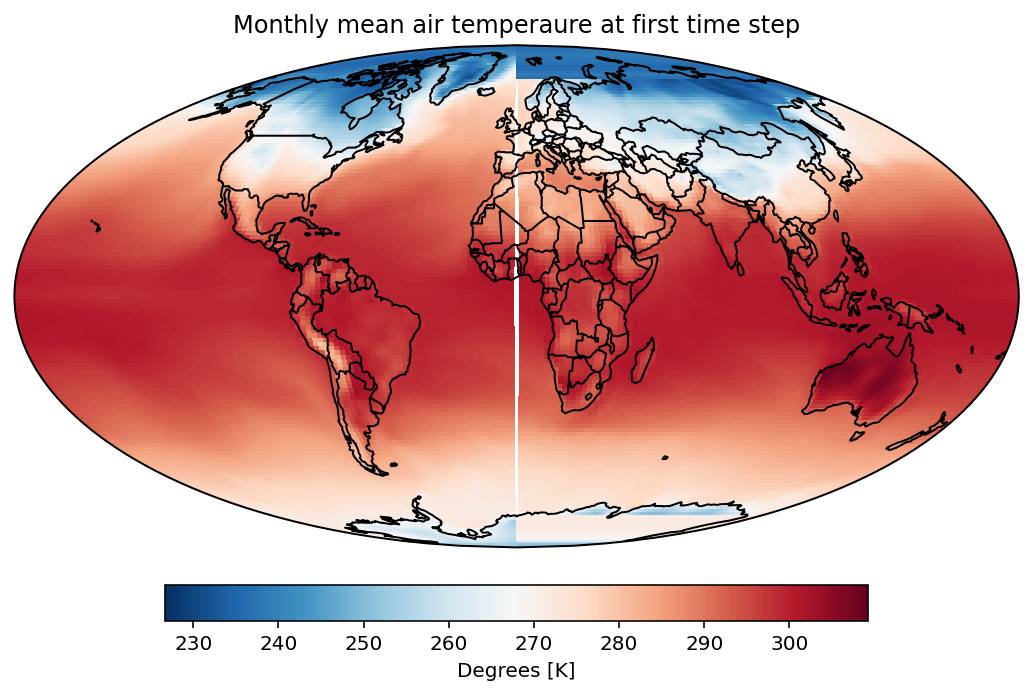

In [25]:
ortho = ccrs.Mollweide() # define target coordinate frame, which is more accurate than using a latlon projection given the large area distortions near the pole
geo = ccrs.PlateCarree() # define origin coordinate frame, which corresponds to the coordinate system of dataArray 

fig, ax = plt.subplots(1, 1, figsize=(9,7), subplot_kw={'projection': ortho}) # setup figure with specific projection

qq = ax.pcolormesh(ds.lon,ds.lat,ds[var][0,:,:],transform = geo, cmap=plt.get_cmap('RdBu_r'))

# Add coastlines and borders
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')

# Add colorbar at the bottom
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
out=fig.colorbar(qq,cax=cax,**kw)
out.set_label('Degrees [K]',size=10)
ax.set_title('Monthly mean air temperaure at first time step');

# Show plot
plt.show()

Since the data set is not cyclic, it creates a plotting problem at the 0 meridian where the 0-180 (East part of graph) and 180-360 (West part of Graph) do not connect. We can resolve this by making the data set cyclic using the `cartopy.util.add_cyclic_point` function. Notice that the apparently missing data around the zero-meridian are now removed.

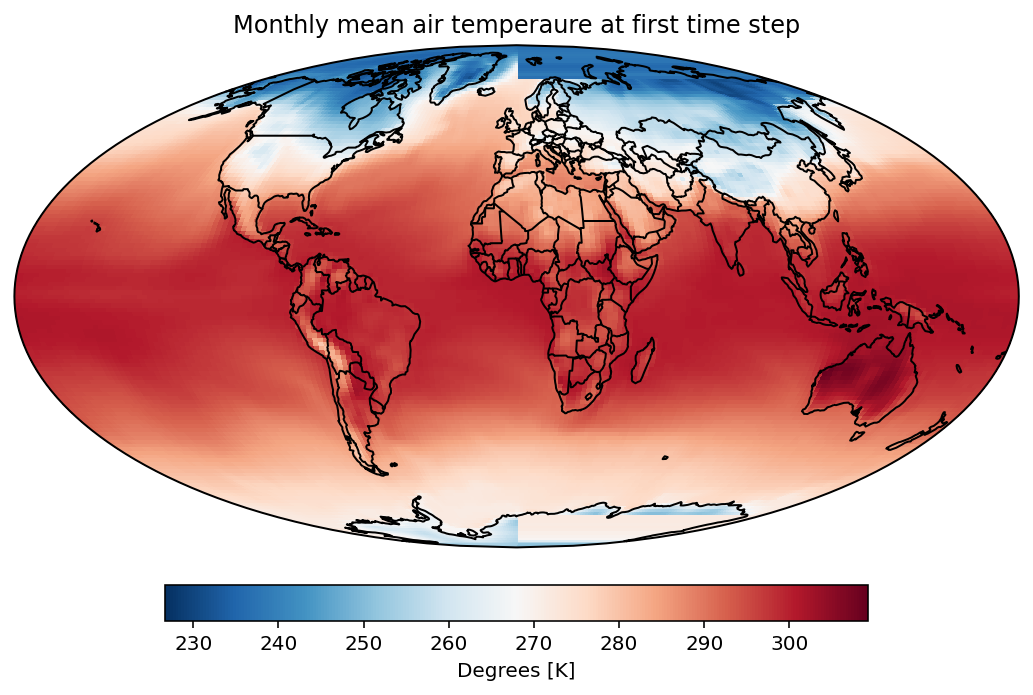

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(9,7), subplot_kw={'projection': ortho}) # setup figure with specific projection

ds2, lons = cartopy.util.add_cyclic_point(ds[var], coord=ds.lon) # Make data cyclic
qq = ax.pcolormesh(lons,ds.lat,ds2[0,:,:],transform = geo, cmap=plt.get_cmap('RdBu_r')) # plot the cyclic data

# Add coastlines and borders
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')

# Add colorbar at the bottom
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
out=fig.colorbar(qq,cax=cax,**kw)
out.set_label('Degrees [K]',size=10)
ax.set_title('Monthly mean air temperaure at first time step');

# Show plot
plt.show()

Or we can calculate the `mean`, `median` per pixel over time and plot these.

In [27]:
ds_mean = ds.mean(dim='time')
ds_median = ds.median(dim='time')

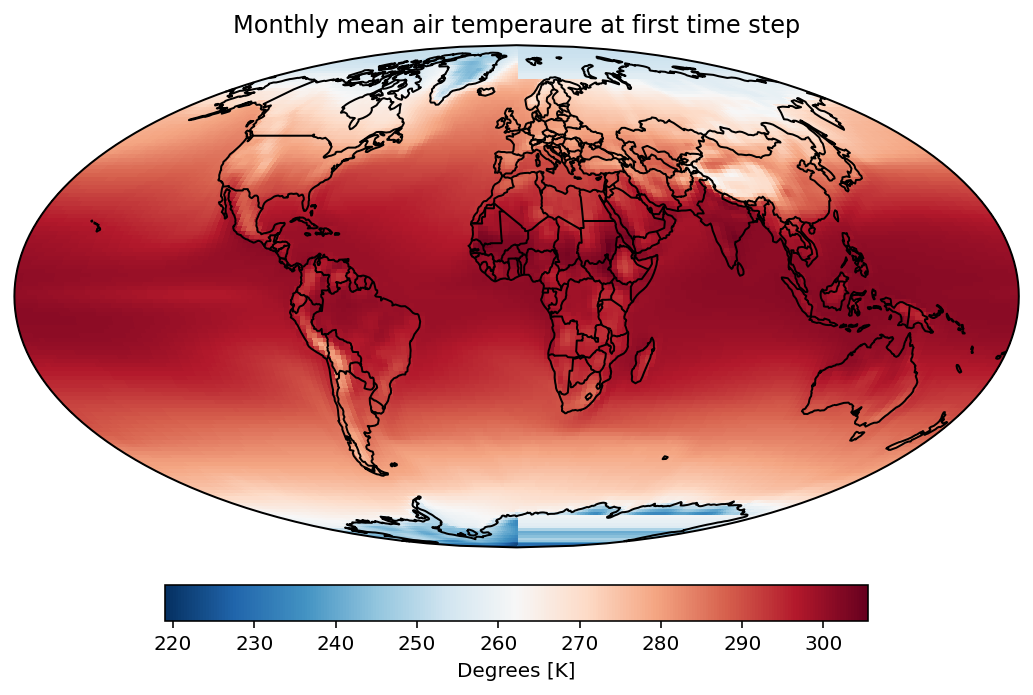

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(9,7), subplot_kw={'projection': ortho}) # setup figure with specific projection

ds2, lons = cartopy.util.add_cyclic_point(ds_mean[var], coord=ds_mean.lon) # Make data cyclic
qq = ax.pcolormesh(lons,ds.lat,ds2,transform = geo, cmap=plt.get_cmap('RdBu_r')) # plot the cyclic data

# Add coastlines and borders
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')

# Add colorbar at the bottom
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
out=fig.colorbar(qq,cax=cax,**kw)
out.set_label('Degrees [K]',size=10)
ax.set_title('Monthly mean air temperaure at first time step');

# Show plot
plt.show()

Or we can calculate whatever quantile we are interested in. However, before doing so, we need to re-arrange the data as the original data are stored in different chunks (in the `time` dimension), which makes the calculation of quantiles complicated. Therefore we need to rechunck the data as the quantile information need all data into one chunk. Notice the difference between:

In [29]:
ds[var].data

dask.array<getitem, shape=(1980, 144, 192), dtype=float32, chunksize=(668, 144, 192), chunktype=numpy.ndarray>

In [30]:
ds.chunk({'time': -1})[var].data

dask.array<rechunk-merge, shape=(1980, 144, 192), dtype=float32, chunksize=(1980, 144, 192), chunktype=numpy.ndarray>

By using the `chunk({'time': -1})` we have removed the chunks over the time dimension, which helps to calculate the quantiles:

In [31]:
ds_q95 = ds.chunk({'time': -1}).quantile(0.99,dim='time') # Calculate the 99th percentile

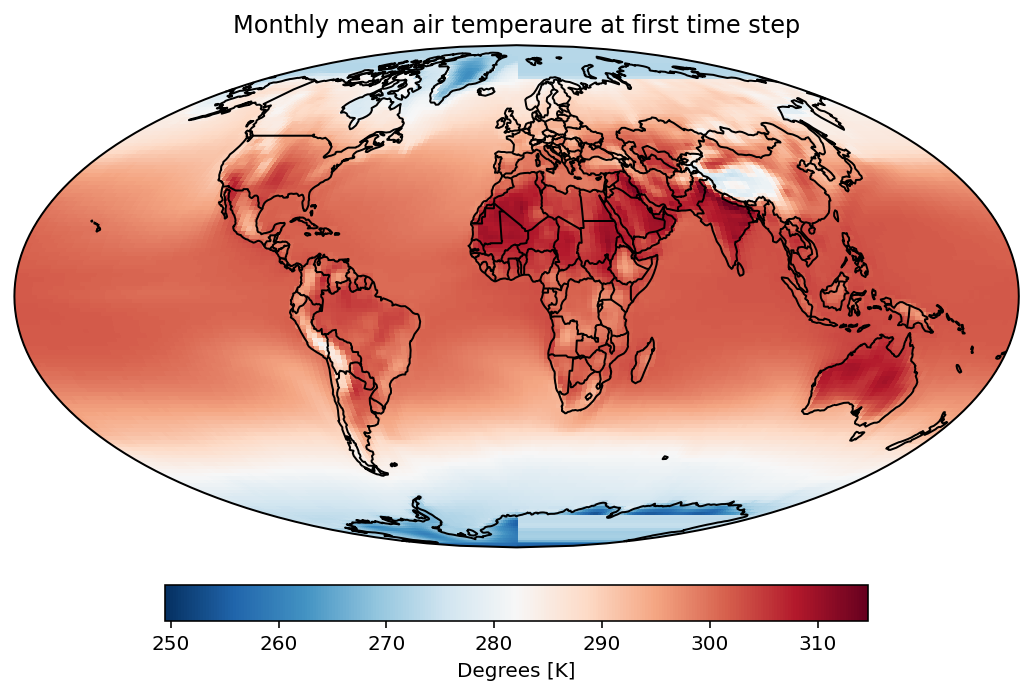

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(9,7), subplot_kw={'projection': ortho}) # setup figure with specific projection

ds2, lons = cartopy.util.add_cyclic_point(ds_q95[var], coord=ds.lon) # Make data cyclic
qq = ax.pcolormesh(lons,ds.lat,ds2,transform = geo, cmap=plt.get_cmap('RdBu_r')) # plot the cyclic data

# Add coastlines and borders
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')

# Add colorbar at the bottom
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
out=fig.colorbar(qq,cax=cax,**kw)
out.set_label('Degrees [K]',size=10)
ax.set_title('Monthly mean air temperaure at first time step');

# Show plot
plt.show()

### Calculate global mean

Our data are currenly structured in a lat/lon grid, but it might also be interesting to study it as global mean values. Therefore, we define a `globalmean` function that calculates the weighted global mean by accounting for the different area corresponding to the different lat/lon cells in our grid.

In [33]:
def globalmean(ds):
    ## Calculate global-mean of our variable by accounting for different areas corresponding 
    ## to different size of lat/lon grid points
    cos_lat_2d = np.cos(np.deg2rad(ds['lat'])) * xr.ones_like(ds['lon']) # effective area weights
    gm = (
        (ds[var] * cos_lat_2d).sum(dim=['lat','lon']) /cos_lat_2d.sum(dim=['lat','lon'])
    )
    return gm.squeeze().compute() # squeeze for removing  the dimensions of length 1 and compute to force the dask lazy computing https://tutorial.dask.org/01x_lazy.html

In [34]:
# Apply global mean on dictionary of xarray datasets and return dictionary
gm_dict = {}
for name, ds in tqdm(ds_dict.items()):
    # Add Global mean to dictionary
    gm_dict[name] = globalmean(ds)

100%|██████████| 42/42 [01:21<00:00,  1.93s/it]


Now let's explore the first data set:

In [35]:
gm = gm_dict[list(ds_dict.keys())[1]]
gm

<xarray.DataArray (time: 1980)>
array([285.19111629, 285.21798211, 286.13884884, ..., 287.93818484,
       287.03025312, 286.45624915])
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00

Let's quickly plot this.

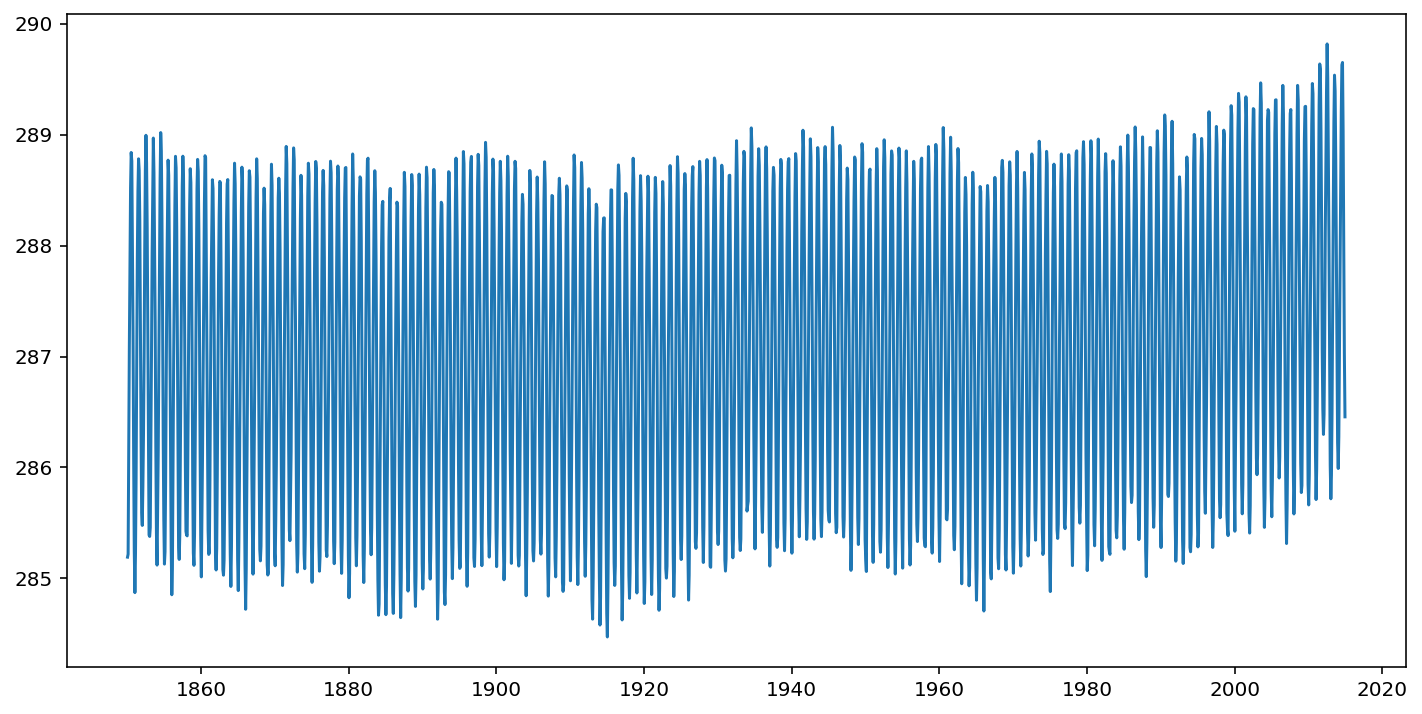

In [36]:
plt.plot(gm.time,gm)

### Calculate anomalies

In the next step we are going to convert the monthly gridded and global mean data sets into anomalies. Therefore, we develop some functions that can be applied (i.e. mapped in a distributed sense) to our dataset.

In [37]:
def monthly_anom(x):
    return (x - x.mean('time'))

def mean_time(x):
    return x.mean('time')

In [38]:
# remove the climatological seasonal cycle from the signal
ds_anom = ds.groupby('time.month').map(monthly_anom).compute()
gm_anom = gm.groupby('time.month').map(monthly_anom).compute()

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 42 times more chunks
  return self.array[key]


In [39]:
# reference this anomaly relative to the 1850 to 1900 pre-industrial period
base_period=slice('1850','1900')
ds_anom = ds_anom - ds_anom.sel(time=base_period).mean(dim='time')
gm_anom = gm_anom - gm_anom.sel(time=base_period).mean(dim='time')

Now let's plot these monthly anomalies:

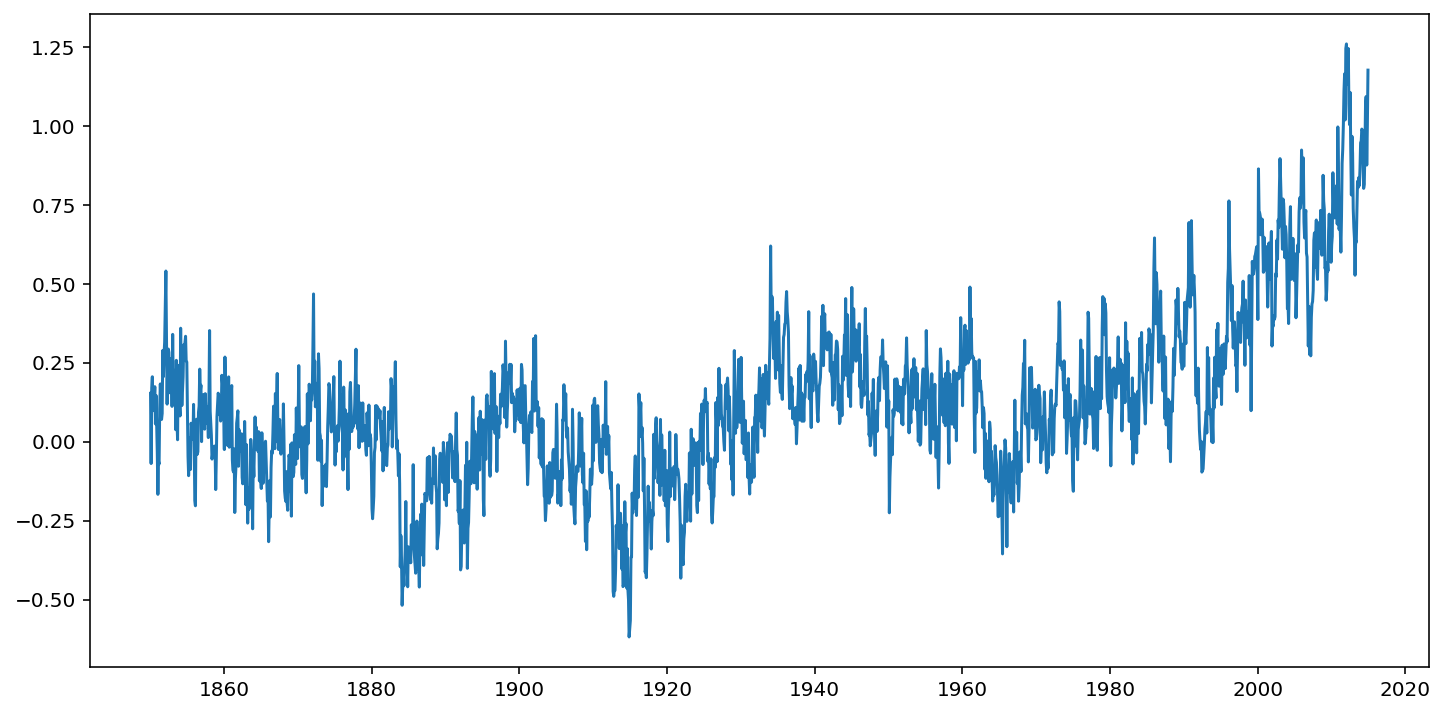

In [40]:
plt.plot(gm_anom.time,gm_anom)

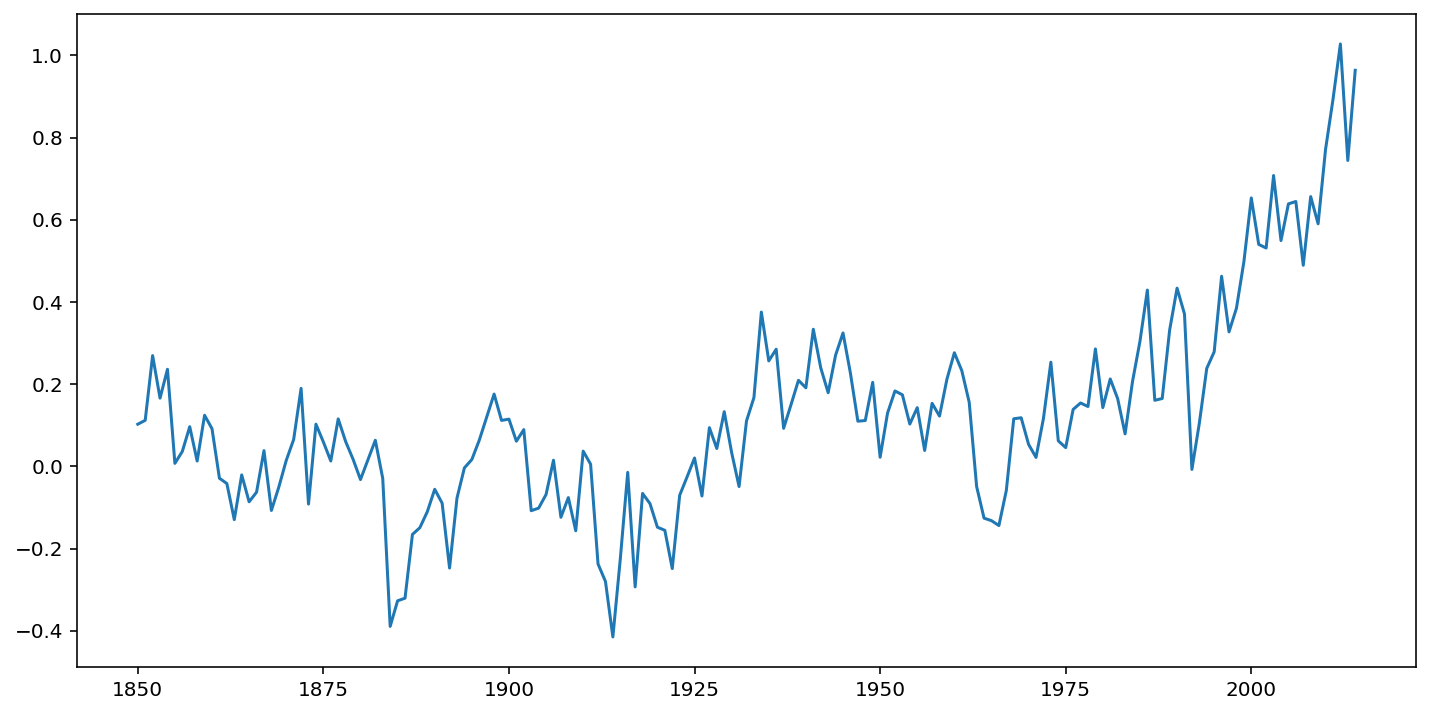

In [41]:
# calculate annual-averages, to smooth the time-series a bit
ds_aanom = ds_anom.groupby('time.year').map(mean_time)
gm_aanom = gm_anom.groupby('time.year').map(mean_time)
plt.plot(gm_aanom.year,gm_aanom)

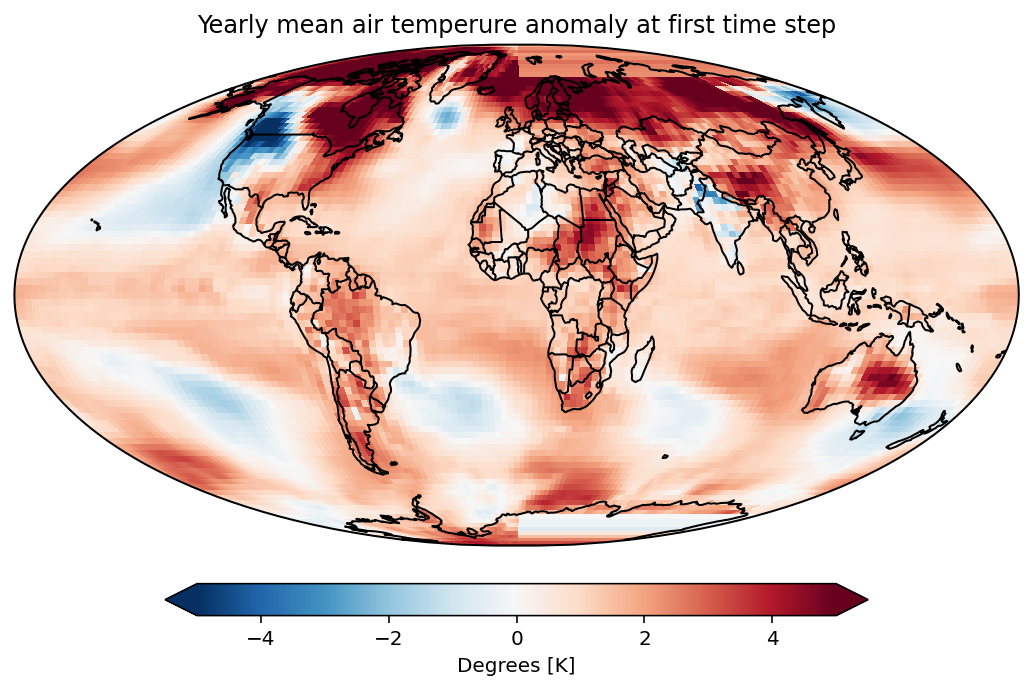

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(9,7), subplot_kw={'projection': ortho}) # setup figure with specific projection

ds2, lons = cartopy.util.add_cyclic_point(ds_anom[var], coord=ds_aanom.lon) # Make data cyclic
qq = ax.pcolormesh(lons,ds_aanom.lat,ds2[-1,:,:],transform = geo, cmap=plt.get_cmap('RdBu_r'),vmin=-5,vmax=5) # plot the cyclic data

# Add coastlines and borders
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')

# Add colorbar at the bottom
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
out=fig.colorbar(qq,cax=cax,extend="both",**kw)
out.set_label('Degrees [K]',size=10)
ax.set_title('Yearly mean air temperure anomaly at first time step');

# Show plot
plt.show()

## Step 4: analyze change

Once we have processed the data we can start looking for change. For example, by comparing the mean of a base period with a new period.

In [43]:
base_period = slice('1890','1910')
new_period = slice('1990','2010')
ds_change = (
    ds[var].sel(time=new_period).mean(dim='time') -
    ds[var].sel(time=base_period).mean(dim='time')
).compute()
ds_change

<xarray.DataArray 'tas' (lat: 90, lon: 144)>
array([[1.4230804, 1.4230804, 1.4230804, ..., 1.4230804, 1.4230804,
        1.4230804],
       [1.5278778, 1.4763641, 1.4858856, ..., 1.6072388, 1.6490784,
        1.6334686],
       [1.5649414, 1.5615082, 1.576355 , ..., 1.4460754, 1.5123138,
        1.5345001],
       ...,
       [2.309784 , 2.3110352, 2.3198853, ..., 2.229782 , 2.2539978,
        2.2795563],
       [2.4003906, 2.3899384, 2.385559 , ..., 2.3691711, 2.3869476,
        2.392746 ],
       [2.6069489, 2.6069489, 2.6069489, ..., 2.6069489, 2.6069489,
        2.6069489]], dtype=float32)
Coordinates:
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0

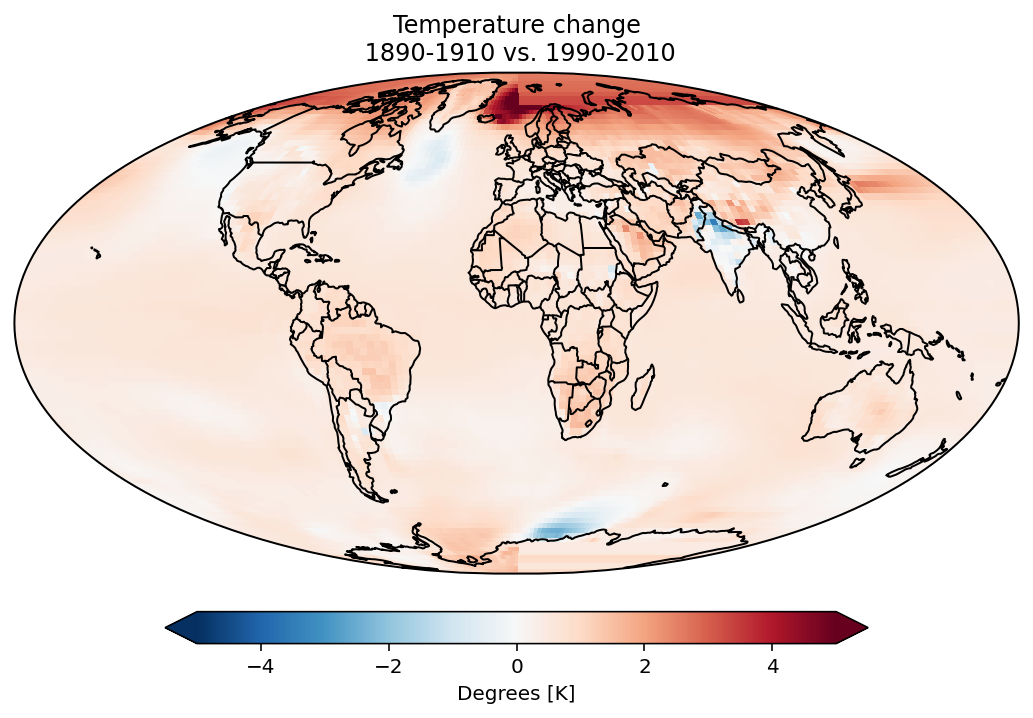

In [44]:
## Plot this change
fig, ax = plt.subplots(1, 1, figsize=(9,7), subplot_kw={'projection': ortho}) # setup figure with specific projection

ds2, lons = cartopy.util.add_cyclic_point(ds_change, coord=ds_change.lon) # Make data cyclic
qq = ax.pcolormesh(lons,ds_change.lat,ds2,transform = geo, cmap=plt.get_cmap('RdBu_r'),vmin=-5,vmax=5) # plot the cyclic data

# Add coastlines and borders
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')

# Add colorbar at the bottom
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
out=fig.colorbar(qq,cax=cax,extend="both",**kw)
out.set_label('Degrees [K]',size=10)
ax.set_title('Temperature change\n 1890-1910 vs. 1990-2010');

# Show plot
plt.show()

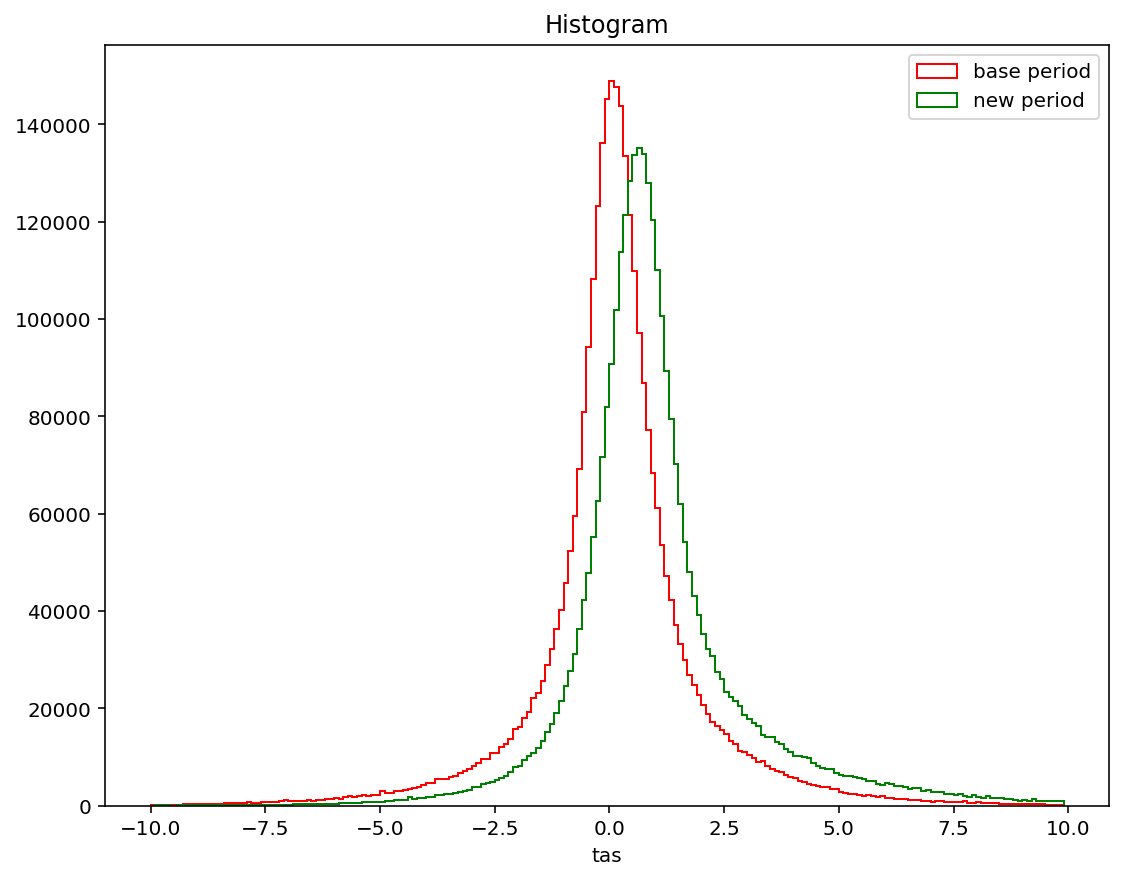

In [48]:
# Calculate distributions for both periods and compare them
bins = np.arange(-10,10,0.1)
fig, ax = plt.subplots(1, 1, figsize=(9,7)) # setup figure 
n, x, y = xr.plot.hist(ds_anom.sel(time=base_period)[var],bins=bins,ax=ax,histtype=u'step',color='red',label='base period')
n, x, y = xr.plot.hist(ds_anom.sel(time=new_period)[var],bins=bins,ax=ax,histtype=u'step',color='green',label='new period')
plt.legend()

From this figure we can see that mean warming was about ~1 degree, but what happened with the warmest months. For example if we compare the 1% warmest months (i.e., 99the percentile).

In [49]:
ds_change = (
    ds[var].sel(time=new_period).chunk({'time': -1}).quantile(0.95,dim='time') -
    ds[var].sel(time=base_period).chunk({'time': -1}).quantile(0.95,dim='time')
).compute()
ds_change

<xarray.DataArray 'tas' (lat: 90, lon: 144)>
array([[0.80946503, 0.80946503, 0.80946503, ..., 0.80946503, 0.80946503,
        0.80946503],
       [0.8499588 , 0.97922363, 1.01764984, ..., 0.82962646, 1.00859451,
        0.99956512],
       [1.09848785, 1.19883728, 1.2468956 , ..., 1.23878479, 1.2604393 ,
        1.22141647],
       ...,
       [0.07378082, 0.04634094, 0.02967987, ..., 0.18965149, 0.16815796,
        0.10569611],
       [0.18433838, 0.1712738 , 0.199823  , ..., 0.16809235, 0.1963623 ,
        0.18482971],
       [0.14434052, 0.14434052, 0.14434052, ..., 0.14434052, 0.14434052,
        0.14434052]])
Coordinates:
  * lon       (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat       (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
    quantile  float64 0.95

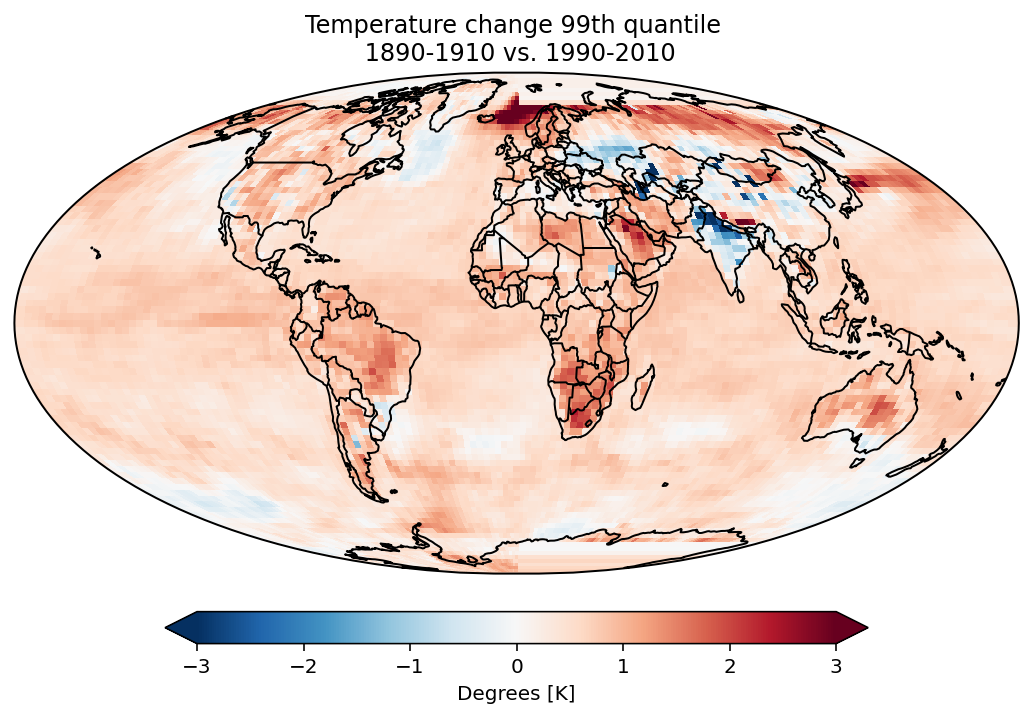

In [54]:
## Plot this change
fig, ax = plt.subplots(1, 1, figsize=(9,7), subplot_kw={'projection': ortho}) # setup figure with specific projection

ds2, lons = cartopy.util.add_cyclic_point(ds_change, coord=ds_change.lon) # Make data cyclic
qq = ax.pcolormesh(lons,ds_change.lat,ds2,transform = geo, cmap=plt.get_cmap('RdBu_r'),vmin=-3,vmax=3) # plot the cyclic data

# Add coastlines and borders
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')

# Add colorbar at the bottom
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
out=fig.colorbar(qq,cax=cax,extend="both",**kw)
out.set_label('Degrees [K]',size=10)
ax.set_title('Temperature change 99th quantile \n 1890-1910 vs. 1990-2010');

# Show plot
plt.show()

Or we could use 2D histograms to show the change in distribution over time:

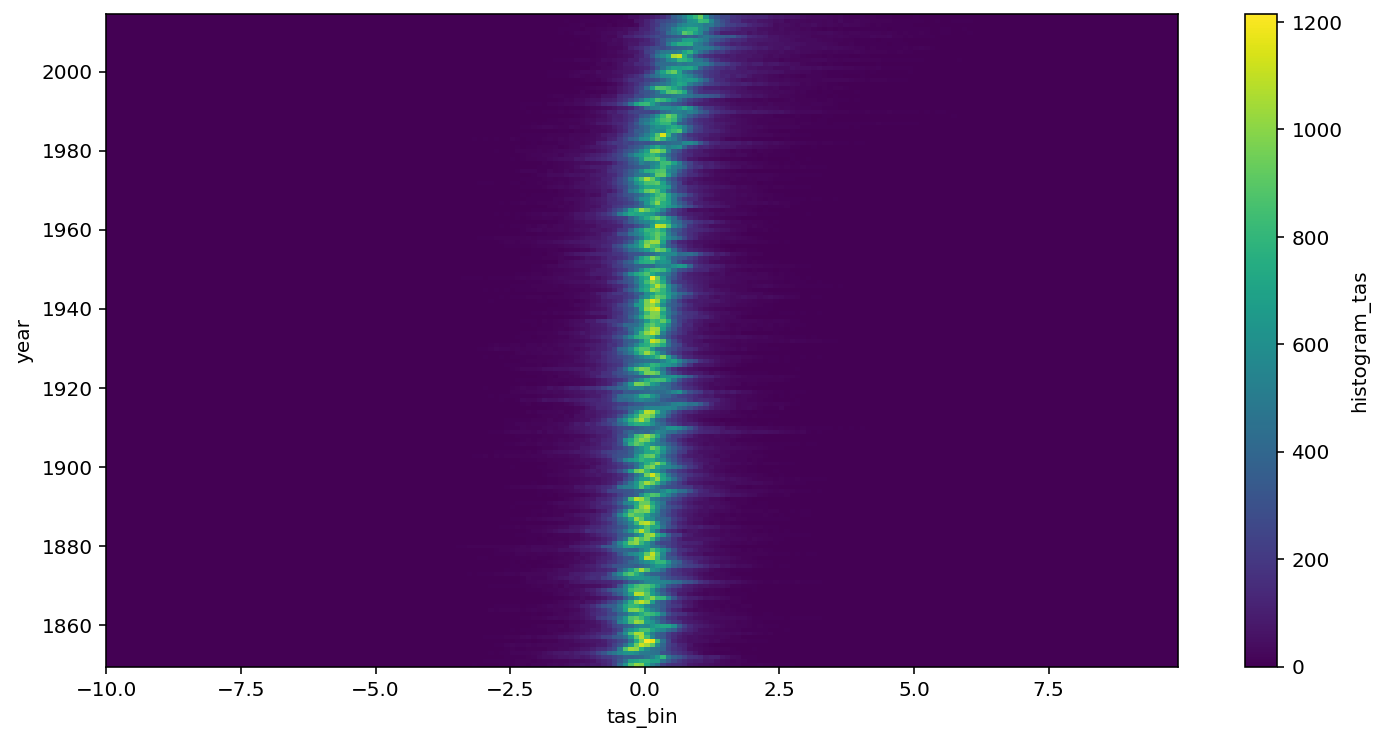

In [55]:
# Or use the histogram package to show change in distributions over time
from xhistogram.xarray import histogram
h_x = histogram(ds_aanom[var], bins=[bins], dim=['lat','lon'])
# Actually we should account for the areas of the different grid cells
cos_lat_2d = np.cos(np.deg2rad(ds['lat'])) * xr.ones_like(ds['lon']) # effective area weights
h_x = histogram(ds_aanom[var], bins=[bins], dim=['lat','lon'],weights=cos_lat_2d)
h_x.plot()

## Step 5: apply on all models

So far we have limited our analysis to one run of one model. Let's apply this now to all our models.

In [56]:
ds_anom_dict = {}
for name, ds in tqdm(ds_dict.items()):
    try:
        # calculate monthly anomaly
        ds_anom = ds.groupby('time.month').map(monthly_anom).compute()
        # substract base period mean
        ds_anom = ds_anom - ds_anom.sel(time=base_period).mean(dim='time')
        # convert to annual anomalies
        ds_aanom = ds_anom.groupby('time.year').map(mean_time)

        ds_anom_dict[name] = ds_aanom.compute()
    except:
        continue

  0%|          | 0/42 [00:00<?, ?it/s]/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 55 times more chunks
  return self.array[key]
  2%|▏         | 1/42 [00:15<10:48, 15.81s/it]/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 55 times more chunks
  return self.array[key]
  5%|▍         | 2/42 [00:33<10:58, 16.46s/it]/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 42 times more chunks
  return self.array[key]
  7%|▋         | 3/42 [01:07<14:04, 21.64s/it]/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 33 times more chunks
  return self.array[key]
 10%|▉         | 4/42 [01:49<17:

In [57]:
gm_anom_dict = {}
base_period = slice('1951','1980') # Is set to 1951-1980 to allow comparison with models
for name, gm in tqdm(gm_dict.items()):
    try:
        # calculate monthly anomaly
        gm_anom = gm.groupby('time.month').map(monthly_anom).compute()
        # substract base period mean
        gm_anom = gm_anom - gm_anom.sel(time=base_period).mean(dim='time')
        # convert to annual anomalies
        gm_aanom = gm_anom.groupby('time.year').map(mean_time)

        gm_anom_dict[name] = gm_aanom.compute()
    except:
        continue

100%|██████████| 42/42 [00:05<00:00,  7.15it/s]


## Step 6: compare to the observations

We can now compare the models with the observations by loading the global mean temperature data set from [GISTEMP v4](https://data.giss.nasa.gov/gistemp/), which is also available in this notebook in the data folder.

In [58]:
# Read the observations as a panda dataframe
import csv
obs = pd.read_csv('data/GLB_Ts+dSST.csv',skiprows=0,header=1,dtype=np.float,na_values='***')
# Convert it into an xarray with Year as a coordinate
xobs = obs.to_xarray().set_coords('Year')
xobs

<xarray.Dataset>
Dimensions:  (index: 141)
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 6 7 8 ... 133 134 135 136 137 138 139 140
    Year     (index) float64 1.88e+03 1.881e+03 1.882e+03 ... 2.019e+03 2.02e+03
Data variables:
    Jan      (index) float64 -0.17 -0.19 0.18 -0.28 ... 1.02 0.82 0.93 1.17
    Feb      (index) float64 -0.23 -0.13 0.15 -0.36 ... 1.14 0.85 0.95 1.24
    Mar      (index) float64 -0.08 0.04 0.05 -0.12 -0.35 ... 1.16 0.9 1.18 1.19
    Apr      (index) float64 -0.15 0.06 -0.15 -0.17 -0.39 ... 0.94 0.9 1.02 1.16
    May      (index) float64 -0.09 0.07 -0.14 -0.17 -0.34 ... 0.9 0.83 0.86 nan
    Jun      (index) float64 -0.2 -0.18 -0.22 -0.07 -0.35 ... 0.72 0.79 0.92 nan
    Jul      (index) float64 -0.17 0.01 -0.15 -0.06 -0.31 ... 0.82 0.83 0.94 nan
    Aug      (index) float64 -0.09 -0.02 -0.06 -0.13 ... 0.87 0.77 0.94 nan
    Sep      (index) float64 -0.14 -0.14 -0.14 -0.2 -0.26 ... 0.79 0.8 0.92 nan
    Oct      (index) float64 -0.22 -0.21 -0.23 -0.1 -0.24 ... 0.9 1.01 1.02 nan
    Nov      (index) float64 -0.21 -0.17 -0.15 -0.22 -0.32 ... 0.89 0.83 1.0 nan
    Dec      (index) float64 -0.17 -0.06 -0.35 -0.1 -0.3 ... 0.95 0.92 1.1 nan
    J-D      (index) float64 -0.16 -0.08 -0.1 -0.16 -0.28 ... 0.92 0.85 0.98 nan
    D-N      (index) float64 nan -0.09 -0.08 -0.18 -0.26 ... 0.92 0.86 0.97 nan
    DJF      (index) float64 nan -0.16 0.09 -0.33 -0.1 ... 1.01 0.87 0.94 1.17
    MAM      (index) float64 -0.11 0.06 -0.08 -0.15 -0.36 ... 1.0 0.88 1.02 nan
    JJA      (index) float64 -0.15 -0.06 -0.14 -0.08 -0.31 ... 0.81 0.8 0.93 nan
    SON      (index) float64 -0.19 -0.17 -0.17 -0.17 ... 0.86 0.88 0.98 nan

#### Compare the models with the observations

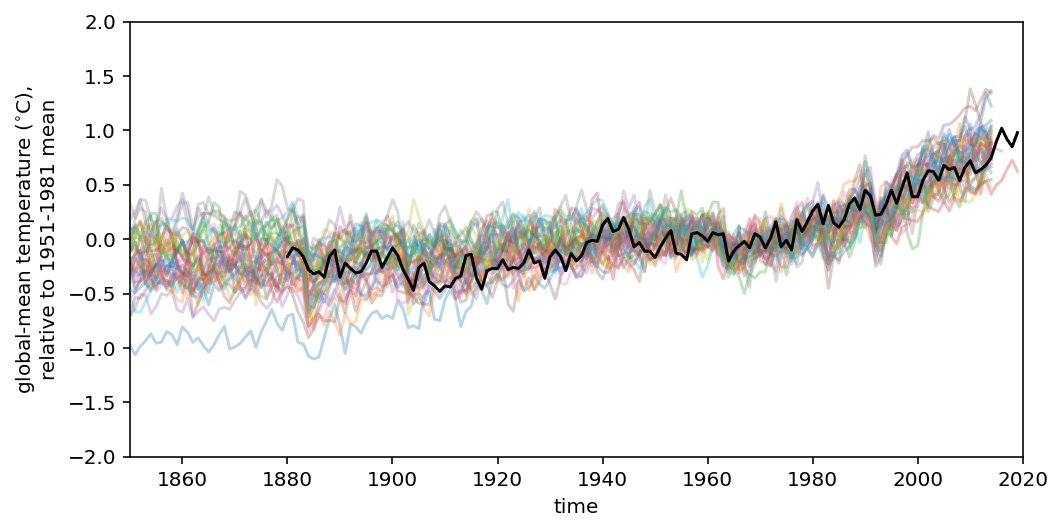

Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/tornado/iostream.py", line 1417, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.7/ssl.py", line 1139, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1076)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/tornado/iostream.py", line 711, in _handle_events
    self._handle_read()
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/tornado/iostream.py", line 1498, in _handle_read
    self._do_ssl_handshake()
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/tornado/iostream.py", line 1435, in _do_ssl_handshake
    return 

In [59]:
plt.figure(figsize=(8,4))

for name, gm in gm_anom_dict.items():
    try:
        plt.plot(gm.year,gm,alpha=0.3)
    except:
        continue
plt.plot(xobs.Year,xobs['J-D'],color='black')
        
plt.xlabel('time')
plt.ylabel(r'global-mean temperature ($^{\circ}$C),'
           '\n'
           'relative to 1951-1981 mean')
plt.xlim([1850,2020])
plt.ylim([-2,2]);
plt.savefig('historical_global_warming.png',dpi=100,bbox_inches='tight')

### Step 7: location based analysis

Let's now select a subset region for a more localized analysis (e.g., for the lat/lon of the netherlands).

In [99]:
ds_neth = ds_anom.sel(lon=slice(3,7)).sel(lat=slice(50,55))
ds_neth[var]

<xarray.DataArray 'tas' (time: 1980, lat: 3, lon: 2)>
array([[[-4.1492873e-01,  2.9326969e-01],
        [-1.5425031e+00, -1.4777046e+00],
        [-2.4479678e+00, -2.4917479e+00]],

       [[ 1.1147953e+00,  1.7353168e+00],
        [ 3.7408620e-04,  3.0497971e-01],
        [-6.0726953e-01, -4.3382555e-01]],

       [[-5.4807693e-01, -6.8521541e-01],
        [-1.2509382e+00, -1.2979256e+00],
        [-1.8936160e+00, -1.9848509e+00]],

       ...,

       [[ 1.2700077e+00,  1.4216266e+00],
        [ 1.7504351e+00,  1.7404655e+00],
        [ 1.8228757e+00,  1.9072695e+00]],

       [[ 3.9624517e+00,  4.1850238e+00],
        [ 3.6068499e+00,  3.6429620e+00],
        [ 3.4404905e+00,  3.2460451e+00]],

       [[ 2.5934331e+00,  2.2677875e+00],
        [ 3.3171771e+00,  3.3784661e+00],
        [ 3.4631040e+00,  3.7034731e+00]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 51.0 53.0 55.0
  * lon      (lon) float64 3.75 6.25
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00

You can see that we have the same data set but as a subset over lat/lon and for this dataset we can do similar types of analyses.

In [102]:
ds_neth[var].mean(dim='time')

<xarray.DataArray 'tas' (lat: 3, lon: 2)>
array([[0.07421426, 0.07580689],
       [0.12113401, 0.14616665],
       [0.1260766 , 0.17249179]], dtype=float32)
Coordinates:
  * lat      (lat) float64 51.0 53.0 55.0
  * lon      (lon) float64 3.75 6.25

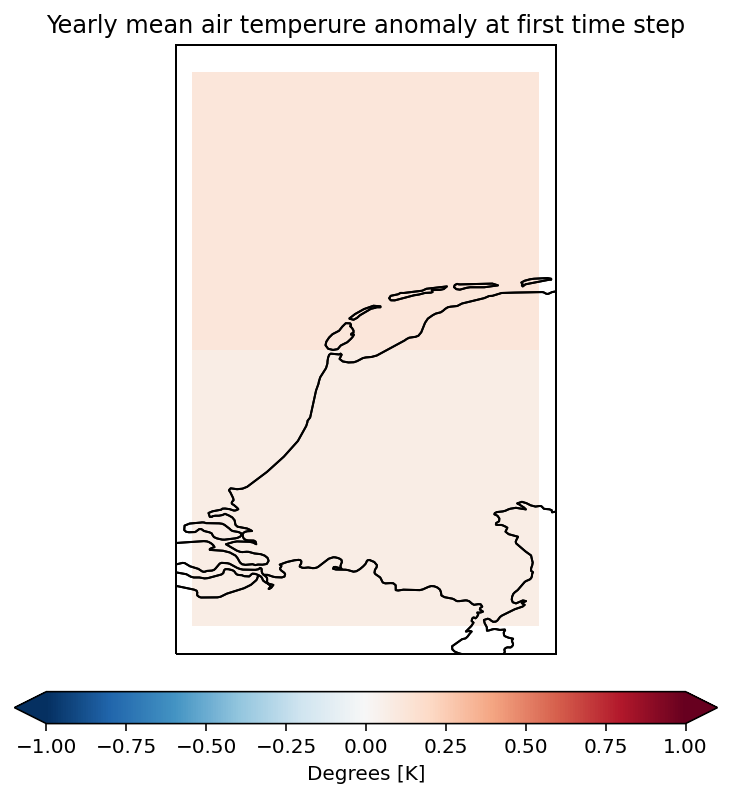

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(9,7), subplot_kw={'projection': geo}) # setup figure with specific projection

qq = ax.pcolormesh(ds_neth.lon,ds_neth.lat,ds_neth[var].mean(dim='time'),transform = geo, cmap=plt.get_cmap('RdBu_r'),vmin=-1,vmax=1) 

# Add coastlines and borders
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'coastline', '10m'), edgecolor='black', facecolor='none')
ax.add_feature(cartopy.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m'), linestyle='-', edgecolor='black', facecolor='none')

# Add colorbar at the bottom
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
out=fig.colorbar(qq,cax=cax,extend="both",**kw)
out.set_label('Degrees [K]',size=10)
ax.set_title('Mean mean air temperure relative to based period');

# Show plot
plt.show()

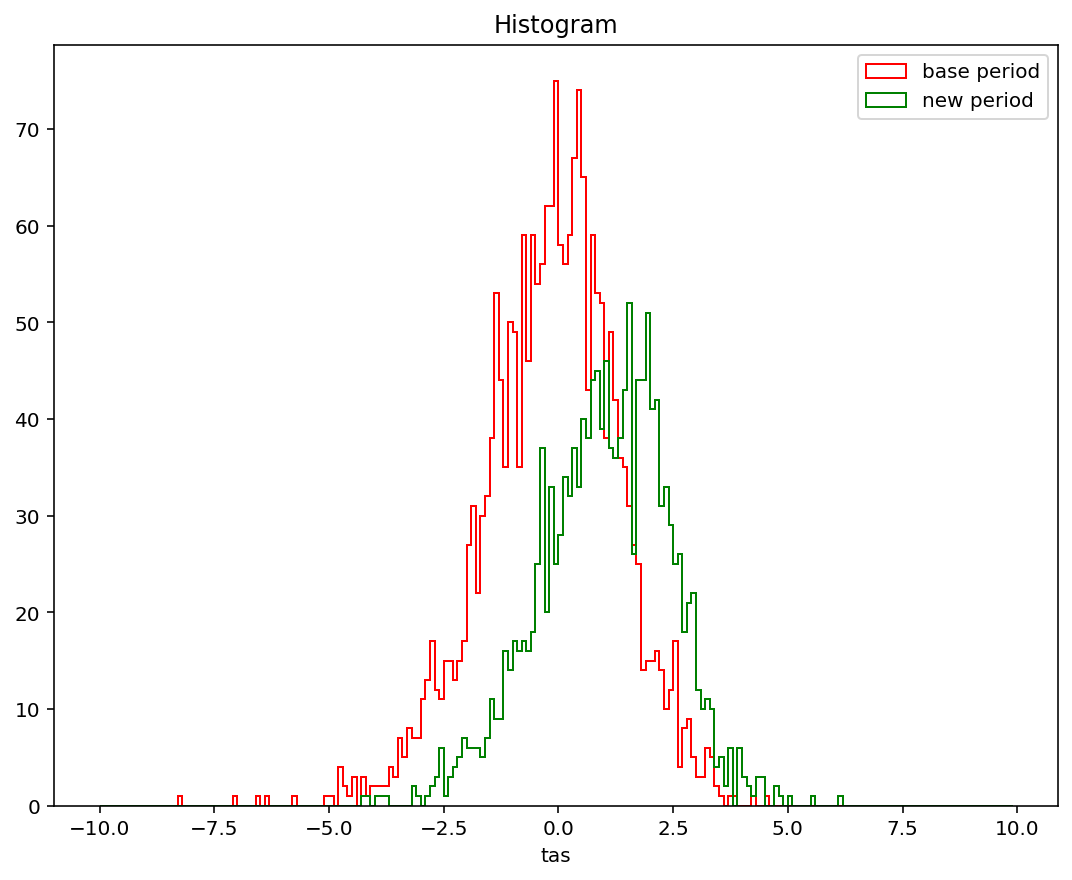

In [104]:
# Calculate distributions for both periods and compare them
bins = np.arange(-10,10,0.1)
fig, ax = plt.subplots(1, 1, figsize=(9,7)) # setup figure 
n, x, y = xr.plot.hist(ds_neth.sel(time=base_period)[var],bins=bins,ax=ax,histtype=u'step',color='red',label='base period')
n, x, y = xr.plot.hist(ds_neth.sel(time=new_period)[var],bins=bins,ax=ax,histtype=u'step',color='green',label='new period')
plt.legend()